In [1]:
# Import my packages.
import flymovie as fm
import os
import copy
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa as tsa

# Activate package autoload.
%load_ext autoreload
%autoreload 2

In [2]:
# Make some test data for fucking around with modeling.
def make_test():
    test = np.array([])
    for i in range(0,20):
        sig = np.random.randn(50)
        buffer = np.repeat(0,20)
        test = np.concatenate([test, sig, buffer])
        #test = np.concatenate([test, sig])
    return test
test = make_test()

/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


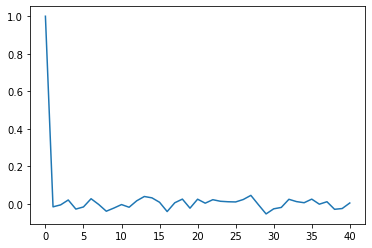

In [3]:
plt.plot(tsa.stattools.acf(test))

Looks like buffering the series with 0s isn't the end of the world. At least provisionally, let's try this. Need a function that combines contiguous stretches of some minimum length...

In [325]:
import itertools
def combine_traces(df, minlen=20, buffer_len=20, buffer_val=0, smooth_window=1):
    """Combine traces from a dataframe into a single numpy vector, distinct traces
    separated by a buffer."""
    def is_nonzero(x):
        if x == 0:
            return False
        return True

    combined = np.array([])
    for tracenum in df:
        trace = df[tracenum].rolling(smooth_window).mean()
        for key, iter in itertools.groupby(trace, key=np.isnan):
            if key == False:
                run = list(iter)
                if len(run) >= minlen:
                    combined = np.concatenate([combined, run, np.repeat(buffer_val, buffer_len)])

    return pd.Series(combined)

def rollingmean_diff(x, rolling=3, diff=1):
    """Perform a rolling average followed by differencing."""
    if diff == 0:
        return x.rolling(rolling).mean()[(rolling - 1):]
    if diff > 0:
        return x.rolling(rolling).mean().diff(diff)[(diff + rolling - 1):]
    else:
        return x.rolling(rolling).mean().diff(diff)[(rolling - 1):diff]

def df_plot_vs_time(df_in, minlen=40, ymin=0, ymax=5000, difference=False, rolling=3, diff=1):
    """Plot mean and standard deviation vs. time for a spot dataframe, with option of 
    differencing and rolling average."""
    df = df_in.copy()
    if difference:
        df = df.apply(lambda x: x.rolling(rolling).mean().diff(diff), axis=0)
    plt.subplot(211)
    plt.plot(np.nanmean(fm.df_filter_minlen(df, 40), axis=1))
    plt.ylim(ymin, ymax);
    plt.title('Mean vs. time')
    plt.subplot(212)
    plt.plot(np.nanstd(fm.df_filter_minlen(df, 40), axis=1))
    plt.title('Stdev vs. Time')

def make_control_vector(x, buffer_val=0):
    control = np.random.randn(len(x))
    control[x == buffer_val] = buffer_val
    return control

def build_lag_matrix(df_dependent, df_independent, nlags, buffer_len=20, buffer_val=np.nan, rolling=1, diff=0):
    dependent = combine_traces(df_dependent, buffer_len=buffer_len, buffer_val=buffer_val)
    dependent = rollingmean_diff(dependent, rolling, diff)
    independent = combine_traces(df_independent, buffer_len=buffer_len, buffer_val=buffer_val)
    independent = rollingmean_diff(independent, rolling, diff)

    lag_mat = np.zeros([len(dependent), (2 * nlags) + 3])
    lag_mat[:,0] = dependent
    #lag_mat[:,1] = independent
    active_col = 1
    for lag in range(-nlags, nlags+1):
        lag_mat[:,active_col] = independent.shift(lag)
        active_col += 1
    return lag_mat

def corr_lag_matrix(lag_mat):
    cc = []
    for col in range(1, lag_mat.shape[1]):
        goodrows = ~np.isnan(lag_mat[:,0]) & ~np.isnan(lag_mat[:,col])
        x = lag_mat[goodrows, 0]
        y = lag_mat[goodrows, col]
        corr = np.cov(x,y)[0,1] / (np.std(x) * np.std(y))
        cc.append(corr)
    return cc
    

So it looks like the acf and pcf for the first difference vectors themselves are ok -- nothing after 0. How do we look at the time series themselves? I guess we can plot the mean vs. time?

Text(0.5, 1.0, 'MS2 no differencing')

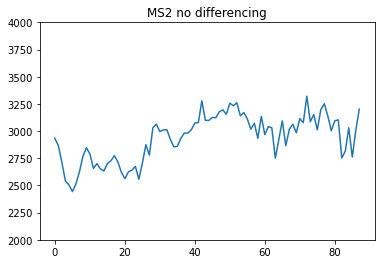

In [8]:
plot_mean_vs_time(eve2.ms2_stdcandle, difference=False, ymin=2000, ymax=4000)
plt.title('MS2 no differencing')

<ipython-input-4-036befea8b93>:34: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fm.df_filter_minlen(df, 40), axis=1))


Text(0.5, 1.0, 'MS2 differencing')

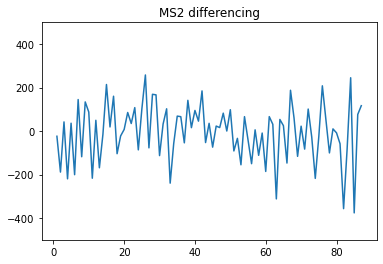

In [9]:
plot_mean_vs_time(eve2.ms2_stdcandle, difference=True, rolling=1, diff=1, ymin=-500, ymax=500)
plt.title('MS2 differencing')

Text(0.5, 1.0, 'Protein: no differencing')

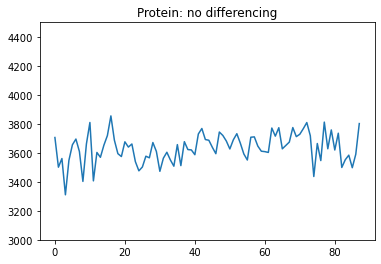

In [10]:
plot_mean_vs_time(eve2.prot_stdcandle, difference=False, ymin=3000, ymax=4500)
plt.title('Protein: no differencing')

<ipython-input-4-036befea8b93>:34: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fm.df_filter_minlen(df, 40), axis=1))


Text(0.5, 1.0, 'Protein differencing')

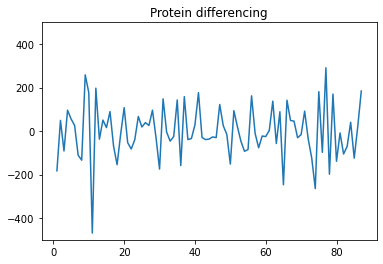

In [11]:
plot_mean_vs_time(eve2.prot_stdcandle, difference=True, rolling=1, diff=1, ymin=-500, ymax=500)
plt.title('Protein differencing')

Wow, one thing that stands out here is how much better the depth-corrected data is (particularly the standard candle corrections). The signal is much more stationary over time. Overall, the protein signal is quite stationary, while the MS2 signal is ok but moves a little. The first differences are very stationary for both.

A question that isn't totallly clear is whether these "buffered" vectors can be considered to be stationary at all. After all they clearly don't have constant means...Unclear at the moment. A control vector seems critical.

<ipython-input-447-972b343744e6>:19: RuntimeWarning: invalid value encountered in double_scalars
  corr = np.cov(x,y)[0,1] / (np.std(x) * np.std(y))


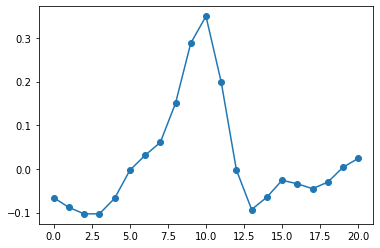

In [458]:
lag = build_lag_matrix(sna.prot_stdcandle, sna.ms2_stdcandle, 10)        
cc = corr_lag_matrix(lag)
plt.plot(cc, marker="o");

In [383]:
df =  eve2.ms2_stdcandle.copy()
test = np.random.randn(df.shape[0], df.shape[1])
#test[np.isnan(df)] = np.nan
test = pd.DataFrame(test)

In [385]:
test

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,0.194753,-0.657769,-0.741228,-1.198525,-0.261206,-0.023986,0.875283,0.042415,0.419491,0.924688,...,0.112577,-0.541360,-0.278084,1.142714,0.019000,0.868051,-0.931836,0.234910,-0.010287,0.906054
1,0.500277,0.972095,0.407737,1.554418,-1.946384,0.265765,1.108456,-0.667898,-1.179735,-1.338170,...,0.597338,-0.637349,0.160098,0.912023,-1.514813,-0.915440,-0.426547,-0.804277,-0.309477,-2.058893
2,0.803315,-0.561510,-0.091403,-1.418754,-0.149828,1.674187,0.246341,-0.549420,1.112802,-0.923114,...,1.111172,0.337542,1.085638,-0.630481,-1.166920,0.684767,0.103428,-0.537212,-0.680697,0.869112
3,0.901190,-0.574583,-1.721289,1.152688,-0.818583,-0.969151,0.604166,-0.078446,0.832441,0.620738,...,-1.232082,-0.307037,-0.432942,-0.454966,-0.255203,-0.423187,1.754819,0.744685,1.054801,-0.006384
4,0.510636,1.074590,0.811627,1.340840,2.248310,1.943370,-0.410894,-1.560535,0.223763,0.380132,...,0.111714,-2.130849,-0.881499,-0.137855,-0.491125,-1.010738,1.706568,-0.697514,1.619226,-0.666601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,0.760173,0.519227,0.182293,1.694548,-0.804476,-0.440761,0.165364,1.533728,0.189010,2.118333,...,0.167699,-0.111884,0.607690,-0.035970,-0.138397,0.545653,-1.190545,0.266595,0.733504,0.257370
84,0.079078,0.848858,-0.526395,0.263287,-1.913465,1.021327,0.314419,-0.108149,1.149906,-1.376232,...,-1.148842,1.658526,1.276195,0.231782,0.145284,0.452563,0.948485,-1.177848,0.801108,-0.327381
85,0.257005,-0.120428,0.641510,-0.706793,-0.387823,-0.971374,-0.503265,-0.035114,0.108851,-1.032284,...,-1.365848,0.892396,-1.205566,0.506242,-0.860567,-0.544387,-1.392082,-0.939691,-1.337874,-0.337311
86,0.706951,0.238683,-0.005307,1.935839,-0.905147,0.256412,-0.290865,1.645795,-0.211118,-1.622408,...,0.466726,0.399647,0.070696,-0.473786,0.491906,0.433560,-0.371818,-0.677028,-1.109733,0.798577


In [17]:
#eve = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210621-rpb1egfp-eve-em2-02-09.pkl')
eve = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210621-rpb1egfp-eve-em3-02-07.pkl')

In [21]:
sna = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210630-rpb1egfp-sna-em3-02.pkl')
#sna = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210701-rpb1egfp-sna-em3-01-07.pkl')

<ipython-input-3-8dc4b5223f0c>:64: RuntimeWarning: invalid value encountered in double_scalars
  corr = np.cov(x,y)[0,1] / (np.std(x) * np.std(y))


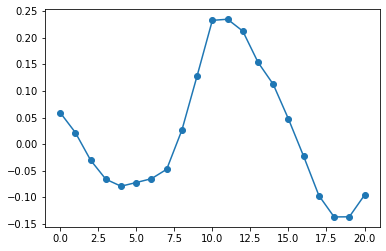

In [24]:
lag_mat = build_lag_matrix(eve.ms2_stdcandle, eve.prot_stdcandle, nlags=10, rolling=3, diff=3)
cc = corr_lag_matrix(lag_mat)
plt.plot(cc, marker="o")

<ipython-input-3-8dc4b5223f0c>:64: RuntimeWarning: invalid value encountered in double_scalars
  corr = np.cov(x,y)[0,1] / (np.std(x) * np.std(y))


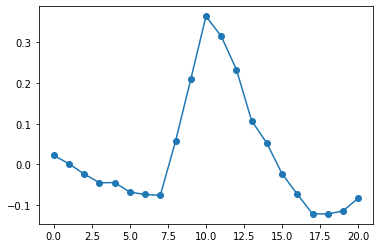

In [25]:
lag_mat = build_lag_matrix(sna.ms2_stdcandle, sna.prot_stdcandle, nlags=10, rolling=3, diff=3)
cc = corr_lag_matrix(lag_mat)
plt.plot(cc, marker="o")

In [94]:
ms2 = combine_traces(sna.ms2_stdcandle, buffer_len=0)
prot = combine_traces(sna.prot_stdcandle, buffer_len=0)

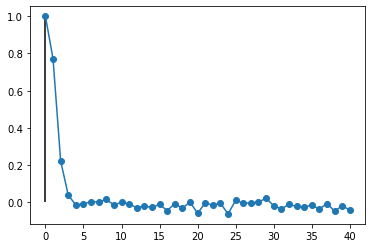

In [42]:
plt.plot(tsa.stattools.pacf(ms2), marker='o')
#plt.plot(tsa.stattools.acf(ms2), marker='o')
plt.vlines(0,0,1)

In [44]:
model = tsa.arima_model.ARMA(ms2, order=(2,0))
model_fit = model.fit()

In [56]:
model_fit.predict()

0       3721.579830
1       4219.961916
2       4252.861163
3       3779.543892
4       4396.296242
           ...     
3716    2622.721836
3717    3144.863141
3718    3456.564309
3719    3437.083356
3720    3349.506561
Length: 3721, dtype: float64

In [62]:
model_fit.predict(start=0, end=100, exog=prot)

0      3721.579830
1      4219.961916
2      4252.861163
3      3779.543892
4      4396.296242
          ...     
96     4885.363739
97     4795.667964
98     3995.174367
99     3717.990314
100    4596.251750
Length: 101, dtype: float64

OK, where are we here? I still don't know how to properly join the time series. I think joining them with no buffer, as long as the component series are sufficiently long, is probably the safest move. Introducing buffers seems to do weird stuff, and the presence of the "fake" junctions will only serve to dilute the real signal rather than introduce weird spurious stuff (I think). For now, let's move forward with the naive joined data and build an ARIMAX model, just seeing where that gets us. We can revisit the joining procedure at a later time.

I do want to try some pre-whitening on the data. It looks like the MS2 traces are well-fit by a low-order AR model (exponentially declining ACF and a few significant PACF lags). How consistent is this across datasets?

Also, how do we pre-treat the series? Smooth? Difference? Lots of moving parts

In [77]:
def plot_acf_pacf(mv):
    ms2 = combine_traces(mv.ms2_stdcandle, buffer_len=0)
    acf = tsa.stattools.acf(ms2)
    pacf = tsa.stattools.pacf(ms2)
    plt.subplot(121)
    plt.bar(range(0, len(acf)), acf)
    plt.subplot(122)
    plt.bar(range(0, len(pacf)), pacf)
    



/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


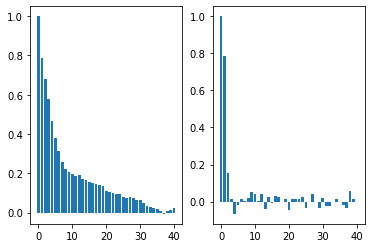

In [78]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210621-rpb1egfp-eve-em2-02-09.pkl')
plot_acf_pacf(mv)

/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


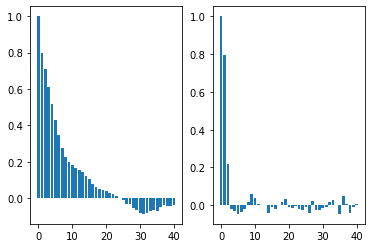

In [79]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210621-rpb1egfp-eve-em3-02-07.pkl')
plot_acf_pacf(mv)

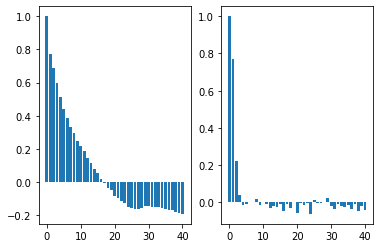

In [80]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210630-rpb1egfp-sna-em3-02.pkl')
plot_acf_pacf(mv)

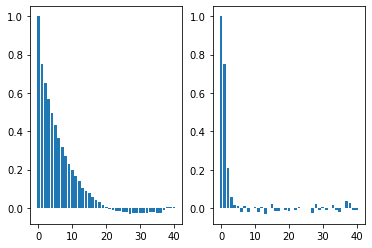

In [81]:
mv = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2_mv_obects/20210701-rpb1egfp-sna-em3-01-07.pkl')
plot_acf_pacf(mv)

OK, so all the original, untreated datasets seem to be well-fit by low-order AR models. Good. What about smoothing? 

Oh I had a maybe obvious idea: maybe acf/pacf on individual traces (or contiguous stretches) and average them?

In [151]:
def df_pretreat(df, smoothing_func='rolling_avg', smoothing_window=3, differencing=False, diff=1):
    """Treat dataframe columns by smoothing and/or differencing."""
    if smoothing_func not in ['rolling_avg']:
        raise ValueError('Invalid smoothing function.')
    df_treated = df.copy()
    if smoothing_func == 'rolling_avg':
        df_treated = df_treated.apply(lambda x: x.rolling(smoothing_window).mean(), axis=0)
    if differencing:
        df_treated = df_treated.apply(lambda x: x.diff(diff), axis=0)
    return df_treated
a = df_pretreat(eve.ms2_stdcandle, smoothing_func='rolling_avg', smoothing_window=1, differencing=True, diff=2)

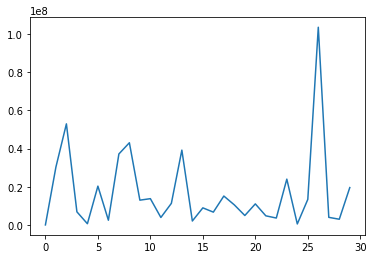

In [101]:
mv = eve
df_ms2 = df_pretreat(mv.ms2_stdcandle)
df_prot = df_pretreat(mv.prot_stdcandle)
ms2 = combine_traces(df_ms2, buffer_len=0)
prot = combine_traces(df_prot, buffer_len=0)
per = scipy.signal.periodogram(ms2)
plt.plot(per[1][:30])

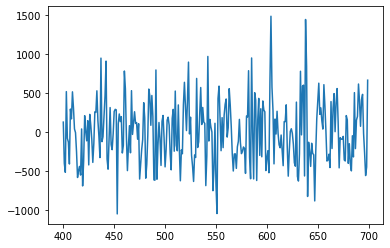

In [114]:
res = ms2.rolling(3).mean() - ms2
plt.plot(res[400:700])

IDEA: join segments with no buffer, randomize order or joins and take average as a way of nulling out junction effects.

In [292]:
def dfs_shuffle_cols(dfs):
    colnums = np.array(dfs[0].columns)
    np.random.shuffle(colnums)
    dfs_shuffled = []
    for df in dfs:
        if df.shape != dfs[0].shape:
            raise ValueError('All dfs must have the same shape.')
        df_shuffled = df.copy()
        df_shuffled = df_shuffled[colnums]
        df_shuffled.columns = np.arange(1, df.shape[1] + 1)
        dfs_shuffled.append(df_shuffled)
    return dfs_shuffled
        
dfs_shuffle_cols([ms2_df])

[             1    2    3    4    5            6    7    8    9           10   \
 0            NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 1            NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 2            NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 3            NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 4            NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 ..           ...  ...  ...  ...  ...          ...  ...  ...  ...         ...   
 106    94.751304  NaN  NaN  NaN  NaN -1273.174528  NaN  NaN  NaN         NaN   
 107  -136.617075  NaN  NaN  NaN  NaN  -285.282643  NaN  NaN  NaN  372.405085   
 108  -912.017638  NaN  NaN  NaN  NaN  -162.286172  NaN  NaN  NaN   -7.864557   
 109 -1715.082892  NaN  NaN  NaN  NaN   248.761008  NaN  NaN  NaN         NaN   
 110          NaN  NaN  NaN  NaN  NaN          NaN  NaN  NaN  NaN         NaN   
 
      ...  102         103

/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


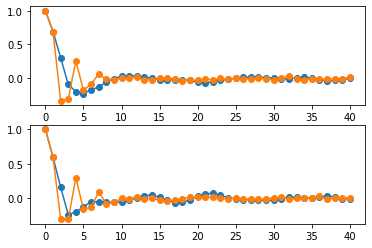

In [243]:
mv = sna
ms2_df, prot_df = dfs_shuffle_cols([mv.ms2_stdcandle, mv.prot_stdcandle])
ms2_df = df_pretreat(ms2_df, differencing=True, diff=3)
prot_df = df_pretreat(prot_df, differencing=True, diff=3)
ms2 = combine_traces(ms2_df, minlen=20, buffer_len=0)
prot = combine_traces(prot_df, minlen=20, buffer_len=0)
plt.subplot(211)
plt.plot(tsa.stattools.acf(ms2), marker='o')
plt.plot(tsa.stattools.pacf(ms2), marker='o')
plt.subplot(212)
plt.plot(tsa.stattools.acf(prot), marker='o')
plt.plot(tsa.stattools.pacf(prot), marker='o')

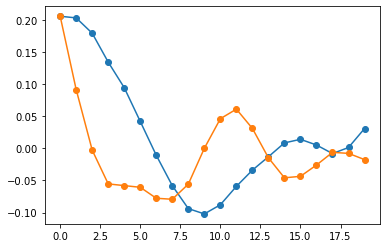

In [279]:
mv = eve
ms2_df, prot_df = dfs_shuffle_cols([mv.ms2_stdcandle, mv.prot_stdcandle])
ms2_df = df_pretreat(ms2_df, smoothing_window=3, differencing=True, diff=3)
prot_df = df_pretreat(prot_df, smoothing_window=3, differencing=True, diff=3)
ms2 = combine_traces(ms2_df, minlen=20, buffer_len=0)
prot = combine_traces(prot_df, minlen=20, buffer_len=0)
plt.plot(tsa.stattools.ccf(ms2, prot)[:20], marker="o")
plt.plot(tsa.stattools.ccf(prot, ms2)[:20], marker="o")

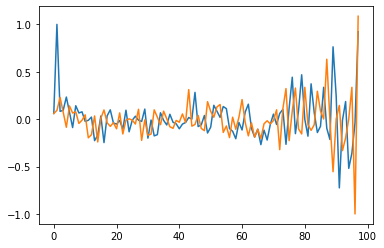

In [272]:
a = pd.Series(np.random.randint(2, size=100))
b = a.shift(-1)
plt.plot(tsa.stattools.ccf(a[1:-1], b[1:-1]))
plt.plot(tsa.stattools.ccf(b[1:-1], a[1:-1]))

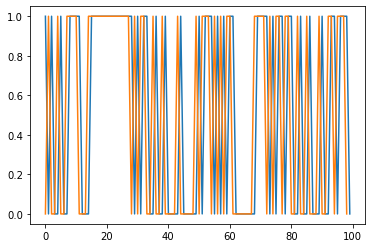

In [273]:
plt.plot(a)
plt.plot(b)

## Directionality of CC

tsa.stattools.ccf(a,b) slides b *to the right* relative to a. So if the values of b lead those in a (as we expect protein signal to lead ms2 signal), then this orientation will yield a positive cc. 

In [276]:
model = tsa.arima_model.ARMA(ms2, order=(2,0))
model_fit = model.fit()
model_fit.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1685
Model:                     ARMA(2, 0)   Log Likelihood              -12408.802
Method:                       css-mle   S.D. of innovations            381.854
Date:                Mon, 09 Aug 2021   AIC                          24825.604
Time:                        17:15:19   BIC                          24847.322
Sample:                             0   HQIC                         24833.648
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.1940     26.395      0.235      0.814     -45.539      57.927
ar.L1.y        0.9748      0.023     42.364      0.000       0.930       1.020
ar.L2.y       -0.3271      0.023    -14.203      0.000      -0.372      -0.282
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4902           -0.9147j            1.7485           -0.0876
AR.2            1.4902           +0.9147j            1.7485            0.0876
-----------------------------------------------------------------------------
"""

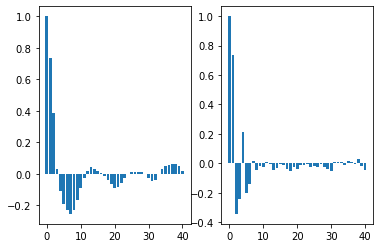

In [316]:
def plot_acf_pacf2(df_in):
    df = dfs_shuffle_cols([df_in])[0]
    x = combine_traces(df, buffer_len=0)
    acf = tsa.stattools.acf(x)
    pacf = tsa.stattools.pacf(x)
    plt.subplot(121)
    plt.bar(range(0, len(acf)), acf)
    plt.subplot(122)
    plt.bar(range(0, len(pacf)), pacf)

plot_acf_pacf2(ms2_df)

<ipython-input-325-7ad73d7f0a4f>:37: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(fm.df_filter_minlen(df, 40), axis=1))
/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


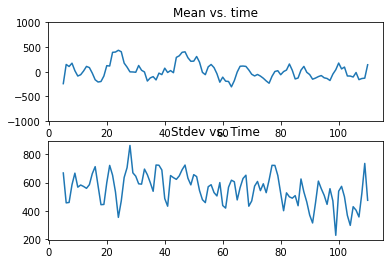

In [328]:
df_plot_vs_time(ms2_df, ymin=-1000, ymax=1000)

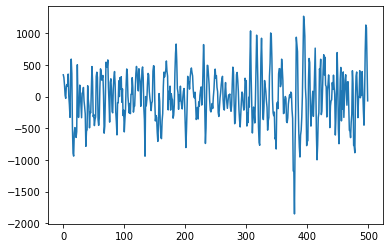

In [332]:
plt.plot(prot[:500])

So the rolling average=3, difference=3 series are reasonably stationary. They have a little auto-correlation, however, so maybe getting rid of this (prewhitening, or just an autoregressive term or two in a model). How does one prewhiten? How do I "apply" an autoregressive model to the endogenous and exogenous dataset?

In [410]:
model = tsa.arima_model.ARMA(ms2, order=(2,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 1685
Model:                     ARMA(2, 0)   Log Likelihood              -12384.689
Method:                       css-mle   S.D. of innovations            376.422
Date:                Tue, 10 Aug 2021   AIC                          24777.377
Time:                        22:21:06   BIC                          24799.095
Sample:                             0   HQIC                         24785.421
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8412     25.763      0.227      0.821     -44.653      56.336
ar.L1.y        1.0004      0.023     43.915      0.000       0.956       1.045
ar.L2.y       -0.3562      0.023    -15.588      0.000      -0.401      -0.311
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4043           -0.9140j            1.6755           -0.0918
AR.2            1.4043           +0.9140j            1.6755            0.0918
-----------------------------------------------------------------------------
"""

/Users/michaelstadler/opt/anaconda3/envs/im/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


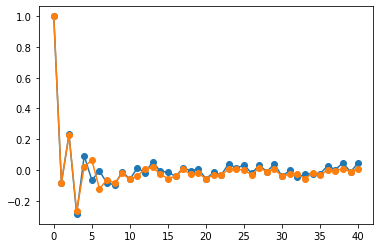

In [358]:
plt.plot(tsa.stattools.acf(model_fit.resid), marker='o')
plt.plot(tsa.stattools.pacf(model_fit.resid), marker='o')

In [363]:
a = model_fit.predict(10,100)

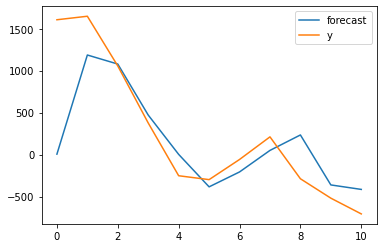

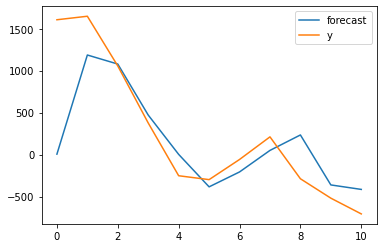

In [389]:
model_fit.plot_predict(end=10)

In [426]:
model_fit.params[0]

5.841234086574286

In [504]:
def filter_ar_model(model_fit, data):
    """Filter a new dataset by the AR model developed for another dataset (prewhitening)."""
    params = model_fit.params
    constant = params[0]
    lag_coeffs = params[1:]
    # Initialize empty filtered data structure.
    filtered_data = np.repeat(np.nan, len(data))
    for pos in range(0, len(data)):
        value = constant
        for i in range(0, len(lag_coeffs)):
            lag_coeff = lag_coeffs[i]
            lag_pos = pos - i - 1
            if lag_pos >= 0:
                value += data[lag_pos] * lag_coeff
        filtered_data[pos] = value
    return pd.Series(filtered_data)

a = filter_ar_model(model_fit, prot)




In [512]:
b = prot - a
cc = tsa.stattools.ccf(model_fit.resid, b)
print(cc)

[ 0.2196663  -0.01685105  0.06798353 ... -0.50839852 -0.67450618
 -1.38962016]


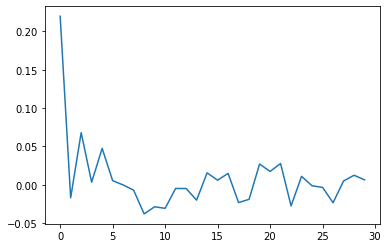

In [511]:
plt.plot(cc[:30])

In [517]:
def norm(x):
    mean_ = np.mean(x)
    std_ = np.std(x)
    return (x - mean_) / std_

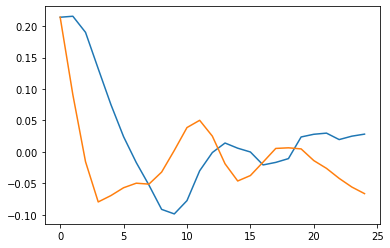

In [551]:
ms2_norm = norm(ms2)
prot_norm = norm(prot)
model = tsa.arima_model.ARMA(ms2_norm, order=(2,0))
model_fit = model.fit()
prot_filtered = filter_ar_model(model_fit, prot_norm)
prot_filtered_resid = prot_norm - prot_filtered.shift(-1)
ms2_resid = ms2_norm - model_fit.predict().shift(-1)
plt.plot(tsa.stattools.ccf(ms2_resid[2:1000], prot_filtered_resid[2:1000])[:25])
plt.plot(tsa.stattools.ccf(prot_filtered_resid[2:1000], ms2_resid[2:1000])[:25])


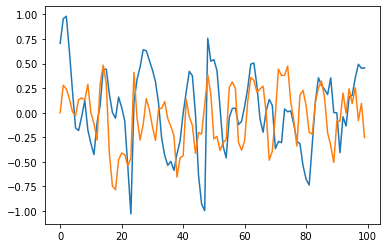

In [533]:
plt.plot(ms2_resid[:100])
plt.plot(prot_filtered_resid[:100])

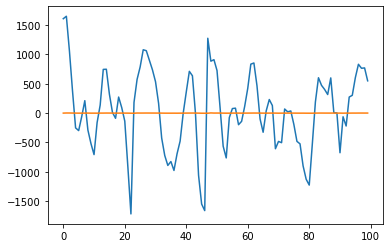

In [531]:
plt.plot(ms2[:100])
plt.plot(model_fit.predict()[:100])

### What have I found?

- Joining time series with buffers doesn't seem effective. For now, the best strategy seems to be to join them directly (no buffer) and randomize the order as a means to overcome junction effects.
- These series are generally not stationary. They can be made stationary through differencing.
- I've experimented with pre-treatment of the data, and I'm still a little shaky on how valid this is. By using some running-average smoothing and using longer-range distances (e.g., 3). This seems to make sense intuitively, but does it create problems analytically or mathematically? Unclear to me at the moment. For now I'll stick with it.
- With smoothing and differencing, there is a significant asymmetry in the ms2-protein cross-correlation. It is in the proper direction (though this should be continually checked--it is very difficult to work out in my head), with significant terms for the correlation of MS2 signal with *prior* values of protein.
- I remained concerned about artefacts, specifically those resulting from auto-correlation in the MS2 signal. I attempted prewhitening. The curious thing is that the AR(2) model from the MS2 signal created a shifted series, one position to the right. Taking the residuals of the MS2 signal and the model predictions, and doing the same for the protein signal filtered with the MS2 AR(2) model parameters and examining their cross-correlation reveals no significant terms (other than 0). However, if I shift the filtered series one to the left, which intuitively *seems* correct, the cross-correlation of the residuals is almost identical to that for the un-prewhitened data, suggesting that the signal is not from the autocorrelation in the MS2 signal.

But what the fuck is going on with the shifting? I'm missing something. I think MAYBE the issue is that 'l1' is actually the 0-lag. I'm searching through documentation and can't fucking understand this. It seems asinine to do that, but...

OK I'm going to try something a bit batty and shift to R momentarily. Going to run a similar analysis using R's time series packages and see what it spits out. 

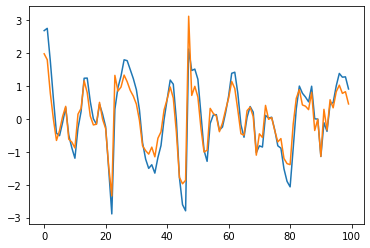

In [554]:
plt.plot(ms2_norm[:100])
plt.plot(model_fit.predict().shift(-1)[:100])

In [557]:
a = np.stack((ms2, prot), axis=1)

In [560]:
np.savetxt('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/ms2prot.csv', a, delimiter=',')